In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModel
import torch
import warnings

/opt/miniconda3/envs/LING413/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_and_prepare_data():
    """
    Downloads (if necessary) and loads the Brown corpus, then splits it
    into training, validation, and test sets.
    """
    print("Step 1: Loading and preparing data...")
    try:
        from nltk.corpus import brown
    except ImportError:
        print("NLTK is not installed. Please install it with 'pip install nltk'")
        return None
    except LookupError:
        print("Downloading the 'brown' corpus from NLTK...")
        nltk.download('brown')
        from nltk.corpus import brown

    categories = brown.categories()
    print(f"Number of genres (classes): {len(categories)}")

    # Construct a dictionary compatible with the 'datasets' library
    data_dict = {
        "text": [" ".join(sent) for file_id in brown.fileids() for sent in brown.sents(fileids=file_id)],
        "label": [categories.index(brown.categories(fileids=file_id)[0]) for file_id in brown.fileids() for sent in brown.sents(fileids=file_id)]
    }

    full_dataset = Dataset.from_dict(data_dict)

    # Split the data: 80% train, 10% validation, 10% test
    train_val_split = full_dataset.train_test_split(test_size=0.2, seed=42)
    test_split = train_val_split['train'].train_test_split(test_size=0.1, seed=42)

    final_splits = DatasetDict({
        'train': test_split['train'],
        'validation': test_split['test'],
        'test': train_val_split['test']
    })

    print("Data loading and splitting complete.")
    print(f"Training set size: {len(final_splits['train'])}")
    print(f"Validation set size: {len(final_splits['validation'])}")
    print(f"Test set size: {len(final_splits['test'])}")
    
    return final_splits, categories

In [3]:
def train_tfidf_model(datasets, categories):
    """
    Trains and evaluates a Logistic Regression model using TF-IDF features.
    """
    print("\nStep 2: Training Model 1 (TF-IDF + Logistic Regression)...")

    # As suggested, use a higher n-gram size to capture more context
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words='english',
        max_features=10000  # Limit feature space to prevent memory issues
    )

    # Fit on training data and transform all splits
    X_train = vectorizer.fit_transform(datasets['train']['text'])
    X_val = vectorizer.transform(datasets['validation']['text'])
    X_test = vectorizer.transform(datasets['test']['text'])

    y_train = datasets['train']['label']
    y_test = datasets['test']['label']

    print("Training the logistic regression classifier...")
    # Increase max_iter to ensure convergence
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    print("Evaluating the model...")
    y_pred = model.predict(X_test)

    print("\n--- TF-IDF Model Results ---")
    print(classification_report(y_test, y_pred, target_names=categories))
    
    cm = confusion_matrix(y_test, y_pred)
    return cm

In [4]:
def get_bert_embeddings(texts, model, tokenizer, device):
    """
    Generates static BERT embeddings for a list of texts.
    We use the mean of the last hidden state as the sentence embedding.
    """
    all_embeddings = []
    # Process in batches to manage memory
    batch_size = 32
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Mean pooling of the last hidden state
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)
    
    return np.vstack(all_embeddings)

In [5]:
def train_bert_embedding_model(datasets, categories):
    """
    Trains and evaluates a Logistic Regression model using static BERT embeddings.
    """
    print("\nStep 3: Training Model 2 (BERT Embeddings + Logistic Regression)...")

    # Setup device, tokenizer, and model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    model_name = 'bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)

    print("Generating BERT embeddings for the dataset (this may take a while)...")
    X_train_bert = get_bert_embeddings(datasets['train']['text'], model, tokenizer, device)
    X_val_bert = get_bert_embeddings(datasets['validation']['text'], model, tokenizer, device)
    X_test_bert = get_bert_embeddings(datasets['test']['text'], model, tokenizer, device)

    y_train = datasets['train']['label']
    y_test = datasets['test']['label']

    print("Training the logistic regression classifier on BERT embeddings...")
    lr_bert_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_bert_model.fit(X_train_bert, y_train)

    print("Evaluating the model...")
    y_pred_bert = lr_bert_model.predict(X_test_bert)

    print("\n--- BERT Embeddings Model Results ---")
    print(classification_report(y_test, y_pred_bert, target_names=categories))

    cm = confusion_matrix(y_test, y_pred_bert)
    return cm

In [6]:
def plot_confusion_matrix(cm, categories, title):
    """
    Plots a confusion matrix using seaborn's heatmap.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

Step 1: Loading and preparing data...
Number of genres (classes): 15
Data loading and splitting complete.
Training set size: 41284
Validation set size: 4588
Test set size: 11468

Step 2: Training Model 1 (TF-IDF + Logistic Regression)...
Training the logistic regression classifier...
Evaluating the model...

--- TF-IDF Model Results ---
                 precision    recall  f1-score   support

      adventure       0.43      0.45      0.44       956
 belles_lettres       0.40      0.59      0.48      1458
      editorial       0.50      0.23      0.31       581
        fiction       0.40      0.33      0.36       871
     government       0.67      0.49      0.57       581
        hobbies       0.53      0.52      0.53       820
          humor       0.95      0.09      0.17       231
        learned       0.48      0.75      0.59      1540
           lore       0.45      0.39      0.42       993
        mystery       0.45      0.36      0.40       804
           news       0.49      0

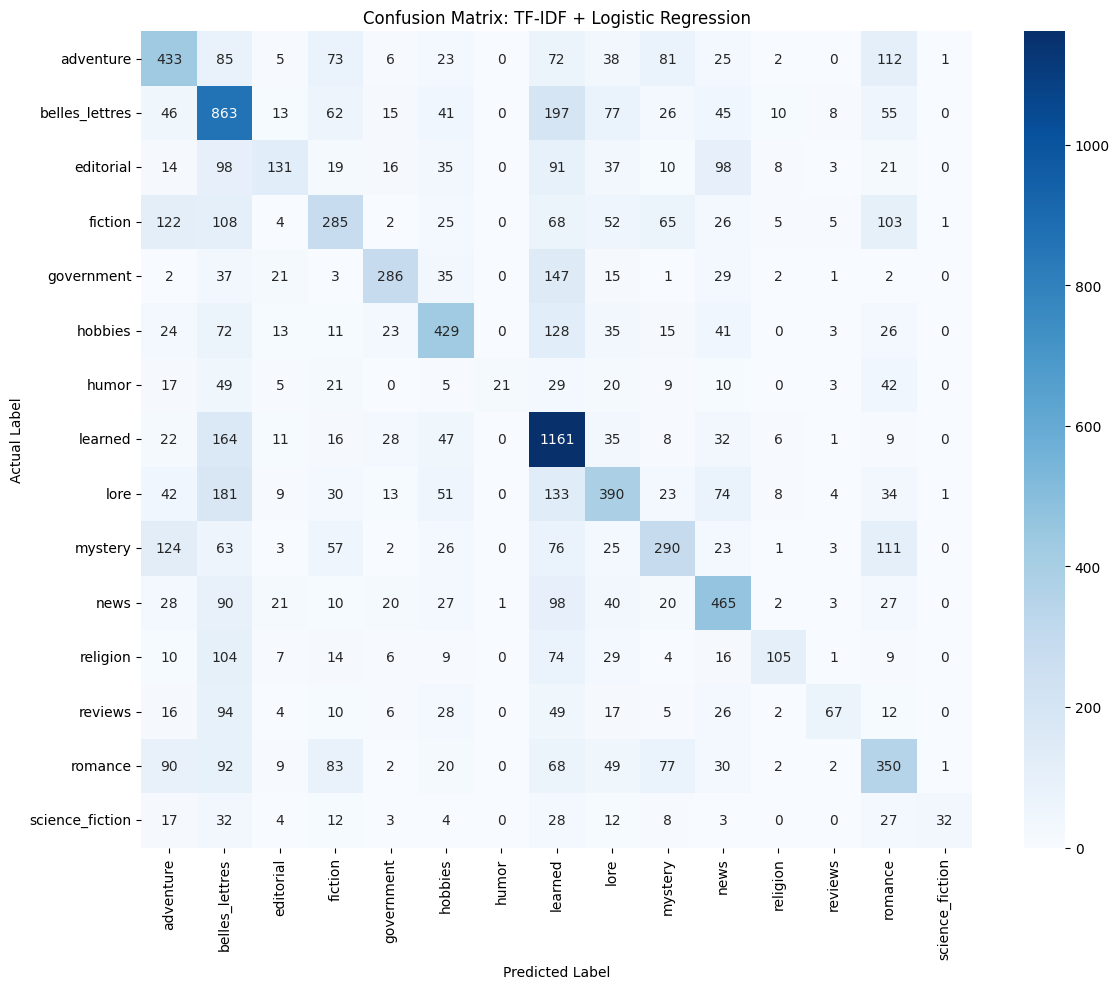


Step 3: Training Model 2 (BERT Embeddings + Logistic Regression)...
Using device: cpu


In [ ]:
datasets, categories = load_and_prepare_data()

if datasets:
    # Step 2: Run TF-IDF Model
    cm_tfidf = train_tfidf_model(datasets, categories)
    plot_confusion_matrix(cm_tfidf, categories, 'Confusion Matrix: TF-IDF + Logistic Regression')
    
    # Step 3: Run BERT Embedding Model
    cm_bert = train_bert_embedding_model(datasets, categories)
    plot_confusion_matrix(cm_bert, categories, 'Confusion Matrix: BERT Embeddings + Logistic Regression')

    print("\nComparison complete. Check the console for reports and plots for visualizations.")